In [1]:
# read the df
import pandas as pd
import numpy as np

df = pd.read_csv('df.csv',index_col=0)
print(df)


# get the column X and Y and store in a ndarray called data_array 
data_array = df[['X', 'Y']].values

                X         Y
Time                       
100.0    0.016431  8.953245
300.0    0.016690  8.754355
500.0    0.016891  8.666372
700.0    0.017029  8.719342
900.0    0.017104  8.846215
...           ...       ...
23100.0  0.018083 -6.008240
23300.0  0.017836 -6.089066
23500.0  0.017535 -5.927870
23700.0  0.017182 -5.947482
23900.0  0.016777 -5.416970

[120 rows x 2 columns]


In [2]:
import pandas as pd
import numpy as np


import pyEDM
import matplotlib.pyplot as plt

def find_best_E(df, E_values, data_column='d18O', 
                lib=None, pred=None, tau=-1, Tp=1, noTime=False):
    """
    df          : DataFrame with columns [Time, data_column]
    E_values    : iterable of embedding dimensions to test
    data_column : name of the column to forecast
    lib         : string specifying the library rows, e.g. '1 900'
    pred        : string specifying the prediction rows, e.g. '901 1851'
    tau         : embedding time-lag (default -1 = let pyEDM guess or use default)
    Tp          : prediction horizon (default 1)
    noTime      : if True, pyEDM will assume there's no separate time column
    """
    N = len(df)
    if lib is None or pred is None:
        # Example: first half for library, second half for prediction
        mid = N // 2
        lib  = f"1 {mid}"
        pred = f"{mid+1} {N}"
    
    results = {}
    for E in E_values:
        # Run Simplex
        simplex_out = pyEDM.Simplex(
            dataFrame = df,
            columns   = data_column,  # library columns
            target    = data_column,  # predict the same variable
            lib       = lib,
            pred      = pred,
            E         = E,
            Tp        = Tp,
            tau       = tau,
            knn       = 0,        # 0 => use E+1 neighbors
            embedded  = False,    # let pyEDM embed for us
            noTime    = noTime,   # if the first column is Time, set noTime=False
            showPlot  = False
        )
        
        # simplex_out is a DataFrame with columns ["Time","Observations","Predictions"]
        obs = simplex_out["Observations"].values
        pred_ = simplex_out["Predictions"].values
        
        # Compute correlation, ignoring NaNs
        valid_idx = ~np.isnan(obs) & ~np.isnan(pred_)
        if np.sum(valid_idx) > 1:
            rho_val = np.corrcoef(obs[valid_idx], pred_[valid_idx])[0,1]
        else:
            rho_val = np.nan
        
        results[E] = rho_val
    
    return results


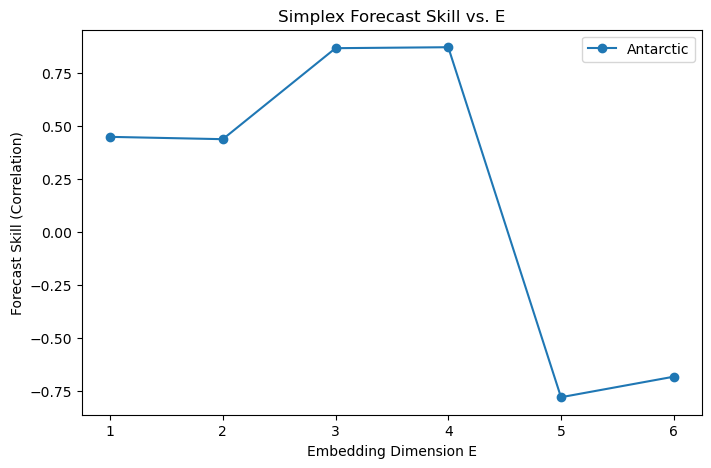

In [8]:
# Range of E to test
E_candidates = range(1, 9)  # 1..8

# Antarctic
ant_results = find_best_E(
    df, 
    E_values = E_candidates, 
    data_column = 'Y',
    tau = 3,           # Example: use time-lag of 1
    Tp = 1,           # 1-step-ahead forecast
    lib='1 40',      # e.g. rows 1..900 as library
    pred='41 81',  # rows 901..1851 as prediction
    noTime=False
)


# Convert dictionary to lists for plotting
E_vals = sorted(ant_results.keys())
ant_rho = [ant_results[E] for E in E_vals]


# Plot
plt.figure(figsize=(8, 5))
plt.plot(E_vals, ant_rho, marker='o', label='Antarctic')

plt.xlabel('Embedding Dimension E')
plt.ylabel('Forecast Skill (Correlation)')
plt.title('Simplex Forecast Skill vs. E')
plt.legend()
plt.show()
